##Task 1.1 Data Preparation

In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn . model_selection import train_test_split
from sklearn.decomposition import PCA


#read dataset
df = pd.read_csv("glass_dataset.csv")
print(df.head(5)) #print first 5 rows to verify
df.info() 
print("\n")

#check for duplicates 
print("Duplicate count : ",df.duplicated().sum(), "\n") #print duplicate count
print(df[df.duplicated(keep=False)], "\n") #print duplicate rows 

df = df.drop_duplicates() #drop duplicates and reassign df
print("Duplicate count : ",df.duplicated().sum(), "\n")

#check for missing values
print(df.isnull().sum())
print("Missing count: ",df.isnull().sum().sum(), "\n")

#separate features from target glass types 
features = df.drop(columns=["Type"])  #glass features
glass = df["Type"]  #glass types

#normalise the dataset
scaler = MinMaxScaler()
scaled = scaler.fit_transform(features)
df_scaled = pd.DataFrame(scaled, columns=features.columns)
df_scaled["Type"] = glass.reset_index(drop=True)

#verify changes 
print("After scaling", df_scaled.max() - df_scaled.min())
print(df_scaled.head(5))

df_scaled.to_csv("glass_dataset_scaled.csv", index=False)


        RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


Duplicat

##Task 1.2 Classification

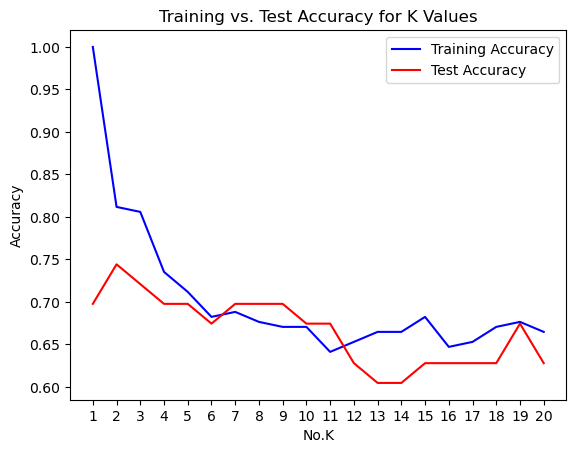

Shape: linear, Train Accuracy: 0.6059, Test Accuracy: 0.5581
Shape: poly, degree 2, Train Accuracy: 0.7118, Test Accuracy: 0.6977
Shape: poly, degree 3, Train Accuracy: 0.7882, Test Accuracy: 0.7209
Shape: rbf, Train Accuracy: 0.7235, Test Accuracy: 0.7442
No. of Components:  1  Variance:  0.4479242510232992
No. of Components:  2  Variance:  0.6304299092272088
No. of Components:  3  Variance:  0.7630125972579062
No. of Components:  4  Variance:  0.8689777592368289
No. of Components:  5  Variance:  0.9316003589681915
No. of Components:  6  Variance:  0.972262507111268
No. of Components:  7  Variance:  0.9952947010877925
No. of Components:  8  Variance:  0.9998542342828859
No. of Components:  9  Variance:  0.9999999999999998


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

#separate features from target glass types 
features = df_scaled.drop(columns=["Type"])  #glass features
glass = df_scaled["Type"]  #glass types

#split data
X_train, X_test, y_train, y_test = train_test_split(features, glass, test_size=0.2, stratify=glass, random_state=42)

#compute optimal no. of neighbours (I can talk about how even though k1 seems optimal it's showing signs of overfitting)
k_values = range(1, 21)
k_train_score = []
k_test_score = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    k_train_score.append(knn.score(X_train, y_train))
    k_test_score.append(knn.score(X_test, y_test))

#plot scores
plt.figure()
plt.xlabel('No.K')
plt.ylabel('Accuracy')
plt.title("Training vs. Test Accuracy for K Values")
plt.plot(k_values, k_train_score, color= 'blue', label= "Training Accuracy")
plt.plot(k_values, k_test_score, color ='red', label = "Test Accuracy")
plt.xticks(k_values)
plt.legend()
plt.show()


#compute optimal kernel shape
s_train_score = []
s_test_score = []
kernel_shape =['linear', 'poly', 'rbf']
for s in kernel_shape:
    if s == 'poly': #if kernel shape is polynomial then limit search to degree 2,3
         for degree in [2,3]:
             svm = SVC(kernel=s, degree=degree)
             svm.fit(X_train, y_train)
             s_train_score.append(svm.score(X_train, y_train))
             s_test_score.append(svm.score(X_test, y_test))
             print(f"Shape: {s}, degree {degree}, Train Accuracy: {s_train_score[-1]:.4f}, Test Accuracy: {s_test_score[-1]:.4f}")
    else:
        svm = SVC(kernel=s)
        svm.fit(X_train, y_train)
        s_train_score.append(svm.score(X_train, y_train))
        s_test_score.append(svm.score(X_test, y_test))
        print(f"Shape: {s}, Train Accuracy: {s_train_score[-1]:.4f}, Test Accuracy: {s_test_score[-1]:.4f}")

    
#check for optimal pca components (maintain highest variance / sweet spot)
variance_result = []
pca_values = range(1, 10)  # testing pca from 1 - 9 dimensions

k_pca_train_score = []
k_pca_test_score = []

s_pca_train_score = []
s_pca_test_score = []

for p in pca_values:
    pca = PCA(n_components=p)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    variance_result.append(sum(pca.explained_variance_ratio_))
    print("No. of Components: ",p, " Variance: ", variance_result[p-1]) 

    



